# PROJECT: Ph.D. ADMISSION SELECTION USING MACHINE LEARNING

Chinmoy Talukdar

In [2]:
#Importing libraries

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
import seaborn as sns
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings("ignore")
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc

ModuleNotFoundError: No module named 'pandas'

In [1]:
url = 'https://drive.google.com/file/d/12Gw_HZ1faZ0DLiRHLqh2xfHqPKFsNTFe/view?usp=sharing'
path = 'https://drive.google.com/uc?export=download&id='+url.split('/')[-2]
data=pd.read_csv(path)
data.head(10)

NameError: name 'pd' is not defined

In [5]:
# 0 = no
# 1 = yes

data['admission_chance'].value_counts()

0    500
1    268
Name: admission_chance, dtype: int64

In [6]:
print(data['admission_chance'])


0      1
1      0
2      1
3      0
4      1
      ..
763    0
764    0
765    0
766    1
767    0
Name: admission_chance, Length: 768, dtype: int64


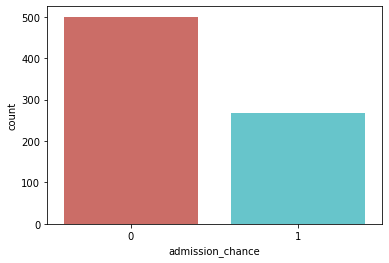

In [7]:
sns.countplot(x='admission_chance', data=data, palette='hls' )
plt.show()

In [8]:
#Segregating variables: Independent and Dependent Variables

X = data.drop('admission_chance', axis = 1)
y = data['admission_chance']

In [9]:
#Splitting the data into train set, cross validation set and the test set

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)


In [10]:
print("train data:", X_train.shape, y_train.shape)
print("test data: ", X_test.shape, y_test.shape)

train data: (614, 3) (614,)
test data:  (154, 3) (154,)


In [11]:
#Using Logistic Regression

clf = LogisticRegression(penalty='l2', random_state=15)
clf.fit(X_train, y_train)

LogisticRegression(random_state=15)

In [12]:
train_pred = clf.predict(X_train)
train_f1 = f1_score(y_train, train_pred)
print("train f1_score ", train_f1)

train f1_score  0.572972972972973


In [13]:
test_pred = clf.predict(X_test)
test_f1 = f1_score(y_test, test_pred)
print("test f1_score ", test_f1)

test f1_score  0.5934065934065933


Fitting 3 folds for each of 9 candidates, totalling 27 fits
best C for given dataset 0.5
tested hyperparameter [0.001 0.05 0.01 0.1 0.5 1 5 10 50]


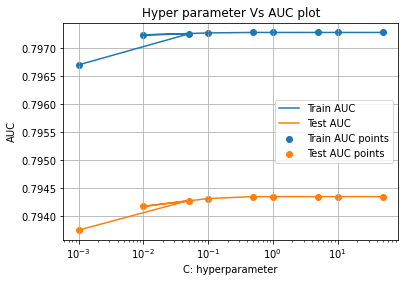

In [14]:
#Hyperparameter tuning for Logistic regression 

lr=LogisticRegression(penalty='l2', random_state=15)
param_grid= {"C": [0.001,0.05,0.01,0.1,0.5,1,5,10,50]}


clf=GridSearchCV(lr, param_grid, cv=3, scoring='roc_auc', verbose=1, return_train_score=True)
clf.fit(X_train, y_train)
#print("best C for given dataset",clf.best_params_)
best_C=clf.best_params_['C']
print("best C for given dataset",best_C)
train_auc=clf.cv_results_['mean_train_score']
train_auc_std=clf.cv_results_['std_train_score']
cv_auc=clf.cv_results_['mean_test_score'] 
cv_auc_std=clf.cv_results_['std_test_score']

C =  clf.cv_results_['param_C']
print("tested hyperparameter",C)

results = pd.DataFrame.from_dict(clf.cv_results_)
results = results.sort_values(['param_C'])

plt.semilogx(C, train_auc, label='Train AUC')

plt.semilogx(C, cv_auc, label='Test AUC')

plt.scatter(C, train_auc, label='Train AUC points')
plt.scatter(C, cv_auc, label='Test AUC points')

plt.legend()
plt.xlabel("C: hyperparameter")
plt.ylabel("AUC")
plt.title("Hyper parameter Vs AUC plot")
plt.grid()
plt.show()


In [15]:
# retraining model using best hyperparameter

clf = LogisticRegression(penalty='l2', random_state=15, C=best_C)
clf.fit(X_train, y_train)

LogisticRegression(C=0.5, random_state=15)

In [16]:
# f1_score for test data

test_pred = clf.predict(X_test)
test_f1 = f1_score(y_test, test_pred)
print("test f1_score ", test_f1)

test f1_score  0.5934065934065933


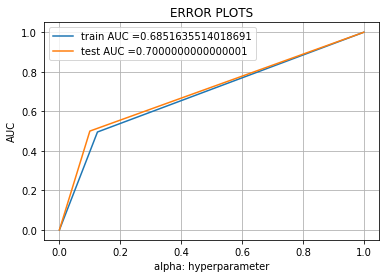

In [17]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve

from sklearn.metrics import classification_report

lr = LogisticRegression(penalty='l2', random_state=15, C=best_C)
lr.fit(X_train, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
auc_logistic = auc(test_fpr, test_tpr)
plt.legend()
plt.xlabel("alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()
#print(auc_logistic)

In [18]:
# we are writing our own function for predict, with defined thresould
# we will pick a threshold that will give the least fpr
def find_best_threshold(threshould, fpr, tpr):
    t = threshould[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t

def predict_with_best_t(proba, threshould):
    predictions = []
    for i in proba:
        if i>=threshould:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

the maximum value of tpr*(1-fpr) 0.433411214953271 for threshold 1


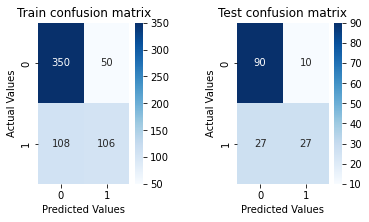

In [19]:
#print("="*100)
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)

plt.subplot(1, 2, 1) # row 1, col 2 index 1
#print("Train confusion matrix")
cm_train_bow = confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t))
sns.heatmap(cm_train_bow, annot=True,fmt="d",cmap='Blues')
plt.title("Train confusion matrix")
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')

plt.subplot(1, 2, 2) # index 2
#print("Test confusion matrix")
cm_test_bow = confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t))
sns.heatmap(cm_test_bow, annot=True,fmt="d",cmap='Blues')
plt.title("Test confusion matrix")
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')

plt.tight_layout(4)
plt.show()

In [20]:
print(classification_report(y_test,predict_with_best_t(y_test_pred, best_t)))

              precision    recall  f1-score   support

           0       0.77      0.90      0.83       100
           1       0.73      0.50      0.59        54

    accuracy                           0.76       154
   macro avg       0.75      0.70      0.71       154
weighted avg       0.76      0.76      0.75       154



# using KNN

clf = KNeighborsClassifier(n_jobs=-1)
clf.fit(X_train, y_train)

In [21]:
train_pred = clf.predict(X_train)
train_f1 = f1_score(y_train, train_pred)
print("train f1_score ", train_f1)

train f1_score  0.572972972972973


In [22]:
test_pred = clf.predict(X_test)
test_f1 = f1_score(y_test, test_pred)
print("test f1_score ", test_f1)

test f1_score  0.5934065934065933


Fitting 3 folds for each of 34 candidates, totalling 102 fits
best K for given dataset 45
tested hyperparameter  [3 5 7 9 11 13 15 17 19 21 23 25 27 29 31 33 35 37 39 41 43 45 47 49 51 53
 55 57 59 61 63 65 67 69]


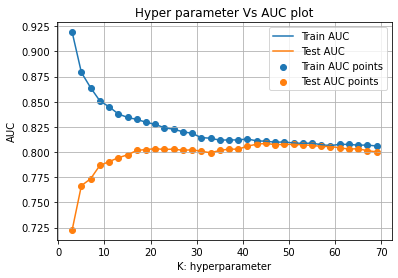

In [23]:
#Hyperparameter tuning for KNeighborsClassifier (K)

knn=KNeighborsClassifier()
param_grid= {"n_neighbors": np.arange(3,70,2)}


clf=GridSearchCV(knn, param_grid, cv=3, scoring='roc_auc', verbose=1, return_train_score=True)
clf.fit(X_train, y_train)
#print("best C for given dataset",clf.best_params_)
best_K=clf.best_params_['n_neighbors']
print("best K for given dataset",best_K)
train_auc=clf.cv_results_['mean_train_score']
train_auc_std=clf.cv_results_['std_train_score']
cv_auc=clf.cv_results_['mean_test_score'] 
cv_auc_std=clf.cv_results_['std_test_score']

K =  clf.cv_results_['param_n_neighbors']
print("tested hyperparameter ",K)

results = pd.DataFrame.from_dict(clf.cv_results_)
results = results.sort_values(['param_n_neighbors'])

plt.plot(K, train_auc, label='Train AUC')

plt.plot(K, cv_auc, label='Test AUC')

plt.scatter(K, train_auc, label='Train AUC points')
plt.scatter(K, cv_auc, label='Test AUC points')

plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("Hyper parameter Vs AUC plot")
plt.grid()
plt.show()

#results.head(5)

In [24]:
# retraining model using best hyperparameter

clf = KNeighborsClassifier(n_jobs=-1, n_neighbors=best_K)
clf.fit(X_train, y_train)

KNeighborsClassifier(n_jobs=-1, n_neighbors=45)

In [25]:
# f1_score for test data

test_pred = clf.predict(X_test)
test_f1 = f1_score(y_test, test_pred)
print("test f1_score ", test_f1)

test f1_score  0.6236559139784946


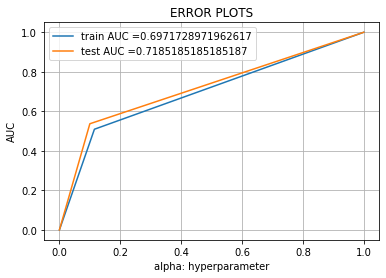

In [26]:
#Testing the performance of the model on test data, plotting ROC Curves

            
lr = KNeighborsClassifier(n_jobs=-1, n_neighbors=best_K)
lr.fit(X_train, y_train)

y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
auc_knn = auc(test_fpr, test_tpr)
plt.legend()
plt.xlabel("alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()
#print(auc_knn)

the maximum value of tpr*(1-fpr) 0.45077102803738317 for threshold 1


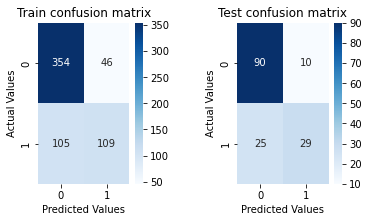

In [27]:
#print("="*100)
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)

plt.subplot(1, 2, 1) # row 1, col 2 index 1
cm_train_bow = confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t))
sns.heatmap(cm_train_bow, annot=True,fmt="d",cmap='Blues')
plt.title("Train confusion matrix")
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')

plt.subplot(1, 2, 2) # index 2
cm_test_bow = confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t))
sns.heatmap(cm_test_bow, annot=True,fmt="d",cmap='Blues')
plt.title("Test confusion matrix")
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')

plt.tight_layout(4)
plt.show()

In [28]:
print(classification_report(y_test,predict_with_best_t(y_test_pred, best_t)))

              precision    recall  f1-score   support

           0       0.78      0.90      0.84       100
           1       0.74      0.54      0.62        54

    accuracy                           0.77       154
   macro avg       0.76      0.72      0.73       154
weighted avg       0.77      0.77      0.76       154



In [29]:
from prettytable import PrettyTable

x = PrettyTable()
x.field_names = ["Model", "Hyperparameter", "AUC"]

x.add_row(["LogisticRegression", best_C, auc_logistic])
x.add_row(["KNeighborsClassifier", best_K, auc_knn])
print(x)

+----------------------+----------------+--------------------+
|        Model         | Hyperparameter |        AUC         |
+----------------------+----------------+--------------------+
|  LogisticRegression  |      0.5       | 0.7000000000000001 |
| KNeighborsClassifier |       45       | 0.7185185185185187 |
+----------------------+----------------+--------------------+
